train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)



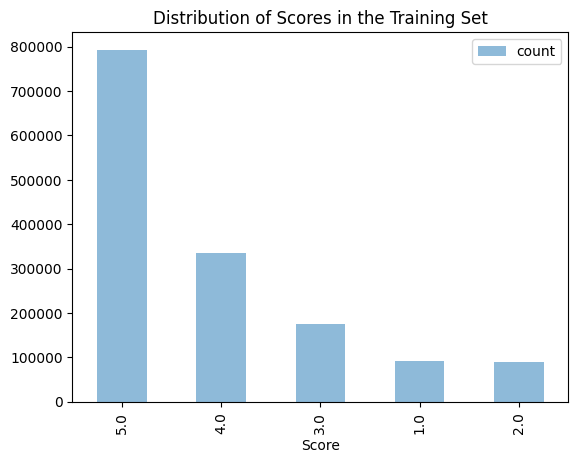

KeyboardInterrupt: 

In [1]:
# Libraries
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler


# Loading the Files
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")


print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)
print()


# Visualization of score distribution
trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.title('Distribution of Scores in the Training Set')
plt.show()


# Adding Features
def add_features_to(df):
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)  
    return df


# Load the feature-extracted files if they've already been generated
if exists('./data/X_train.csv'):
  X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
  X_submission = pd.read_csv("./data/X_submission.csv")
else:
    train = add_features_to(trainingSet)
    X_submission = pd.merge(testingSet, train, on='Id', how='left')
    X_submission = X_submission.drop(columns=['Score_x'])  
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})
    X_train = train[train['Score'].notnull()]


    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)


# Sample + Split into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),  # Features
    X_train['Score'],  # Target
    test_size=0.25,  # 25% for testing
    random_state=0
)


# Feature Selection
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness']
X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]


# Scaling Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_select)
X_test_scaled = scaler.transform(X_test_select)
X_submission_scaled = scaler.transform(X_submission_select)


# Hyperparameter Tuning using GridSearchCV for KNN
param_grid = {'n_neighbors': range(1,100)}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid_search.fit(X_train_scaled, Y_train)


print("Best number of neighbors: ", grid_search.best_params_['n_neighbors'])


# Evaluate with cross-validation
cv_scores = cross_val_score(grid_search.best_estimator_, X_train_scaled, Y_train, cv=5)
print("Cross-validation accuracy: ", cv_scores.mean())


# Predict the score using the best model
Y_test_predictions = grid_search.best_estimator_.predict(X_test_scaled)


# Model Evaluation
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix of the Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Create submission file
X_submission['Score'] = grid_search.best_estimator_.predict(X_submission_scaled)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/final_submission.csv", index=False)